
# <p style="text-align: center;">MIS 382N: ADVANCED PREDICTIVE MODELING - MSBA</p>
# <p style="text-align: center;">Assignment 5 - BONUS - SECTION-A (3.30pm to 5pm class)</p>
## <p style="text-align: center;">Points: 95, Bonus: 40 </p>
## <p style="text-align: center;">Due: November 30, submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Your partner needs to be from the same section. Only one student per team needs to submit the assignment on Canvas.  But be sure to include name and UTEID for both students.  Homework groups will be created and managed through Canvas, so please do not arbitrarily change your homework group. If you do change, let the TA know. 

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)

### Name(s)
1. Joseph (Alex) McGraw jam27652
2. Alexandre Nicolaï 29675

# Question 1 : Bayesian Belief Networks (15 pts)

![Question 1](https://i.imgur.com/3ayVbFi.jpeg) 

All nodes are binary and can take 0/1 values

The probabilities are given below:

P(Bark = 1) = 0.05   
P(Rain = 1) = 0.01


P(Scared = 1 | Bark = 0, Rain = 0) = 0.001  
P(Scared = 1 | Bark = 0, Rain = 1) = 0.1  
P(Scared = 1 | Bark = 1, Rain = 0) = 0.8  
P(Scared = 1 | Bark = 1, Rain = 1) = 0.9  

P(Hides = 1 | Scared = 1) = 0.95  
P(Hides = 1 | Scared = 0) = 0.05  

For the given Bayesian network, Compute the following probabilities :  


**(a) (4 pts)** Find the probability that cat hides = 1.  
**(b) (4 pts)** Given that cat got scared (Scared = 1), what is the probability that it rained (Rain = 1)?  
**(c) (7 pts)** Given that cat got scared (Scared = 1) and the dog barked (Bark = 1), what is the probability that it rained (Rain = 1)?

### A

P(hides| scared=T, bark=F, rain=F) = .001 * (1-.05) * (1-.01) = 0.0094%

P(hides| scared=T, bark=T, rain=F) = 0.8 * (.05) * (1-.01) = 3.96%

P(hides| scared=T, bark=F, rain=T) = 0.1 * (1-.05) * (.01) = 0.095%

P(hides| scared=T, bark=T, rain=T) = 0.9 * 0.05 * 0.01 = 0.045%

sum of 4 probabilities = 4.1094%


P(hides=1)

.95(.041094) + .05(1-.041094) = .0390393 + .0479453 = .0869846 == 8.70%

### B 

P(rain| scared=T) = (P(scared=T| rain) * P(rain)) / P(scared=T)

P(scared=T | rain=T) = P(scared=T, rain=T) / P(rain=T) = (0.095% + 0.045%) / 0.01% = 14%

P(scared=T) = sum of 4 probabilities (Part A) = 4.1094%

P(rain| scared=T) = .14 * .01 / .041094 = 0.034 = 3.4%

### C
P(rained=T| scared=T, barked=T) = P(scared=T, barked=T| rained=T) * P(rained=T) / P(scared=T, barked=T)

P(scared=T, barked=T | rained=T) = P(scared=T, barked=T, rained=T) / P(rained=T) = .00045 / .01 = .045

P(scared=T, barked=T) = .0396 + .00045 = .04005

P(rained=T| scared=T, barked=T) = (.045 * .01) / .04005 = .01124 = 1.124%

# Question 2 - **Random Forest (30 pts)**  

The goal of this problem is to explore the effect of feature selection using  the following dataset (same as in HW 4) https://www.kaggle.com/wendykan/lending-club-loan-data

Since the dataset is really huge, we will use only a certain set of features and samples to build our model. We will also use only two classes instead of all.

The modified dataset with reduced number of samples has been prepared for your use. The file can be downloaded using the code below. You can also find it [here](https://drive.google.com/file/d/1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs/view?usp=sharing) in case you have a different environment and this code does not run.



In [1]:
%%bash
ggID='1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  

if [ -e "${filename}" ]; then
    echo 'File already exists'
else
    curl -Lb /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  
fi

File already exists


In [2]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)
df.head()


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,...,last_pymnt_d_Feb-2019,last_pymnt_d_Jan-2019,last_pymnt_d_Jul-2018,last_pymnt_d_Nov-2018,last_pymnt_d_Oct-2018,last_pymnt_d_Sep-2018,application_type_Individual,application_type_Joint App,debt_settlement_flag_N,debt_settlement_flag_Y
0,2500,2500,2500.0,13.56,84.92,55000.0,1,18.24,9.0,1.0,...,1,0,0,0,0,0,1,0,1,0
1,30000,30000,30000.0,18.94,777.23,90000.0,1,26.52,13.0,1.0,...,1,0,0,0,0,0,1,0,1,0
2,5000,5000,5000.0,17.97,180.69,59280.0,1,10.51,8.0,0.0,...,1,0,0,0,0,0,1,0,1,0
3,4000,4000,4000.0,18.94,146.51,92000.0,1,16.74,10.0,0.0,...,1,0,0,0,0,0,1,0,1,0
4,30000,30000,30000.0,16.14,731.78,57250.0,1,26.35,12.0,0.0,...,1,0,0,0,0,0,1,0,1,0


Select the `loan_status` column as the target column.  


**Part 1: (3 pts)** Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Print the total number of features. 

**Part 2: (5 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  

**Part 3: (6 pts)** Use [$\chi^2$ test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

**Part 4: (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

**Part 5: (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  

**Part 6: (2 pts)** What do you observe from the ROC curves?

# Solution

Part 1: (3 pts) Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform Min-Max Scaling on the dataset. Print the total number of features.

In [3]:
from sklearn.preprocessing import MinMaxScaler

y = df['loan_status']
X = df.drop(['loan_status'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .25)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Number of variables to train on:", len(X.columns))

Number of variables to train on: 160


Part 2: (5 pts) Use the dataset to create a RandomForestClassifier(n_estimators=5, random_state=42) model and print the classification_report to show the precision, recall and F1 score based on the test set.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

RFC = RandomForestClassifier(n_estimators=5, random_state=42).fit(X_train, y_train)
pred = RFC.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.63      0.37      0.46       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.81      0.68      0.73     56517
weighted avg       0.98      0.99      0.99     56517



Part 3: (6 pts) Use  𝜒2
χ
2
  test to select the top 100, 30 and 10 features using SelectKBest module. Train a random forest model and print the classification_report for each of the trained models.

Note:  𝜒2
χ
2
  test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)

In [5]:
from sklearn.feature_selection import chi2, SelectKBest

#100
SKB100 = SelectKBest(chi2, k=100)
X_train_100 = SKB100.fit_transform(X_train, y_train)
X_test_100 = SKB100.transform(X_test)

RFC100 = RandomForestClassifier(n_estimators=5, random_state=42).fit(X_train_100, y_train)
pred_100 = RFC100.predict(X_test_100)
print("100 variable report:\n", classification_report(y_test, pred_100))

100 variable report:
               precision    recall  f1-score   support

           0       0.65      0.45      0.53       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.82      0.72      0.76     56517
weighted avg       0.99      0.99      0.99     56517



In [6]:
#30
SKB30 = SelectKBest(chi2, k=30)
X_train_30 = SKB30.fit_transform(X_train, y_train)
X_test_30 = SKB30.transform(X_test)

RFC30 = RandomForestClassifier(n_estimators=5, random_state=42).fit(X_train_30, y_train)
pred_30 = RFC30.predict(X_test_30)
print("30 variable report:\n", classification_report(y_test, pred_30))

30 variable report:
               precision    recall  f1-score   support

           0       0.49      0.13      0.21       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.98     56517
   macro avg       0.74      0.56      0.60     56517
weighted avg       0.98      0.98      0.98     56517



In [7]:
#10
SKB10 = SelectKBest(chi2, k=10)
X_train_10 = SKB10.fit_transform(X_train, y_train)
X_test_10 = SKB10.transform(X_test)

RFC10 = RandomForestClassifier(n_estimators=5, random_state=42).fit(X_train_10, y_train)
pred_10 = RFC10.predict(X_test_10)
print("10 variable report:\n", classification_report(y_test, pred_10))

10 variable report:
               precision    recall  f1-score   support

           0       1.00      0.07      0.14       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.99      0.54      0.56     56517
weighted avg       0.99      0.99      0.98     56517



Part 4: (6 pts) Plot the ROC curves for all of the 4 models.

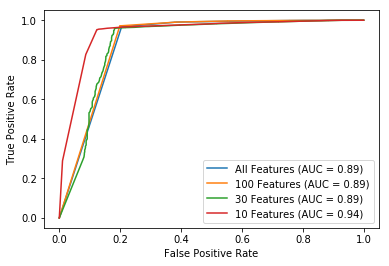

In [8]:
%matplotlib inline
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(RFC, X_test, y_test, name='All Features')
plot_roc_curve(RFC100, X_test_100, y_test, ax=disp.ax_, name='100 Features')
plot_roc_curve(RFC30, X_test_30, y_test, ax=disp.ax_, name='30 Features')
plot_roc_curve(RFC10, X_test_10, y_test, ax=disp.ax_, name='10 Features')

Part 5: (8 pts) Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. (Get feature names after feature selection, Plot feature importance using Pandas and matplotlib)

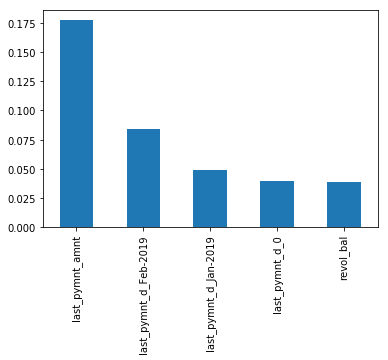

In [9]:
# Top 5 from all features
#All_top5 = RFC.get_support(indices=True)
#X_train = pd.DataFrame(X_train, columns=X.columns)
#All_features = X_train.iloc[:,All_top5]

allFeat = pd.Series(RFC.feature_importances_, index=X.columns)
allFeat.nlargest(5).plot(kind='bar')

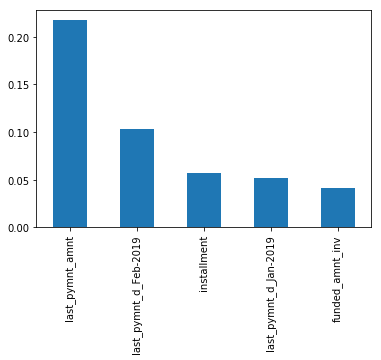

In [10]:
# Top 5 from 100 important features
SK100_top5 = SKB100.get_support(indices=True)
X_train = pd.DataFrame(X_train, columns=X.columns)
SK100_features = X_train.iloc[:,SK100_top5]

featPlot100 = pd.Series(RFC100.feature_importances_, index=SK100_features.columns)
featPlot100.nlargest(5).plot(kind='bar')

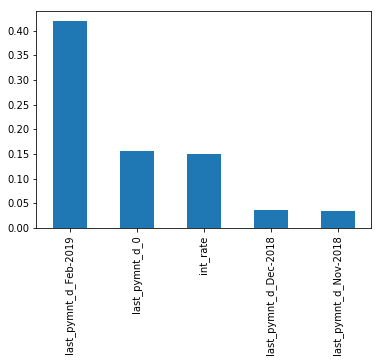

In [11]:
# Top 5 from 30 important features
SK30_top5 = SKB30.get_support(indices=True)
X_train = pd.DataFrame(X_train, columns=X.columns)
SK30_features = X_train.iloc[:,SK30_top5]

featPlot30 = pd.Series(RFC30.feature_importances_, index=SK30_features.columns)
featPlot30.nlargest(5).plot(kind='bar')

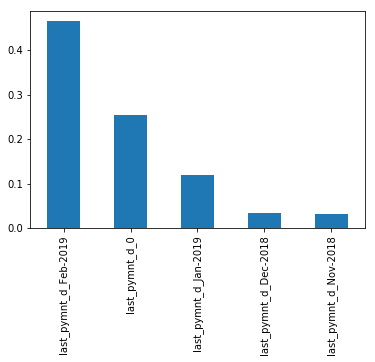

In [12]:
# Top 5 from 10 important features
SK10_top5 = SKB10.get_support(indices=True)
X_train = pd.DataFrame(X_train, columns=X.columns)
SK10_features = X_train.iloc[:,SK10_top5]

featPlot10 = pd.Series(RFC10.feature_importances_, index=SK10_features.columns)
featPlot10.nlargest(5).plot(kind='bar')

Part 6: (2 pts) What do you observe from the ROC curves?

The model with only 10 features performed significantly better than the other models. It had the highest true positive, and lowest false positive rate out of all of the models. 

# Question 3 : Logistic Regression with Regularization and Decision Tree (25 pts)

The goal of this problem is to explore the effect of regularization on logistic regression for binary classification, we will be using the diabetes dataset. 
This dataset is used to predict if a person is having 
diabetes based on feature variables including blood pressure, bmi, age etc. The target variable is stored in "outcome" column.

* Load the "diabetes.csv" and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 


* We need to use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on the original data, we use StandardScaler to center each feature. Also remember that when we have training and testing data, we fit preprocessing parameters on training data and apply them to all testing data. You should scale only the features (independent variables), not the target variable y. 

   Note: X should have 8 features.


**Part 1: (6 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty $l2$
(Ridge Regularization) for the following values of regularization  C = $[0.0001,0.001,0.1,10,100]$ using the training data. Report the accuracy score on the test data averaged over 5 runs of the model for each of the C values. 

  Note : Smaller values of C indicate stronger regularization

    

**Part 2: (6 pts)** Fit a [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier on the training data, and report the accuracy score on the test data averaged over 5 runs. Briefly explain which of the models performed the best Logistic Regression + regularization or Decision Tree Classifier and why. 


* Now, We will check if the decision boundary from logistic regression is linear by using a 2D plot.


**Part 3: (4 pts)** Select the top two most important features ([Feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)) using the training data with a Decision Tree Classifier and random_state = 10. Subset the train and test data to have only the selected features. This will be used as the training and test data for part $4$.


**Part 4: (8 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty = $l2$, C = 10 (Ridge Regularization) and random state = 0 for the training data from part $3$ . Plot the decision boundary of the logistic regression model with the two features, as X and Y axis. Here is an [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html) . Plot the scatter points for the test data, on the same graph showing the two classes as two different color. 

  * Hint : You can use the below limits for plotting the decision boundary, where $X[:,0]$ indicates feature 1 values and $X[:,1]$ indicates feature 2 values of the train dataset. 

     $ x_\min, x_\max = X[:, 0].min() - .5, X[:, 0].max() + .5 $ 

     $ y_\min, y_\max = X[:, 1].min() - .5, X[:, 1].max() + .5 $
   

# Solution

#### Loading dataset and pre-processing (**1 pt**)

In [13]:
from sklearn.preprocessing import StandardScaler

diabetes = pd.read_csv('diabetes.csv')

y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Part 1 (**6 pts**)

Fit a logistic regression model with penalty  𝑙2
l
2
  (Ridge Regularization) for the following values of regularization C =  [0.0001,0.001,0.1,10,100]
[
0.0001
,
0.001
,
0.1
,
10
,
100
]
  using the training data. Report the accuracy score on the test data averaged over 5 runs of the model for each of the C values.
Note : Smaller values of C indicate stronger regularization

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

acc_scores = pd.Series(index=[0.0001,0.001,0.1,10,100])

for i in [0.0001,0.001,0.1,10,100]:
    model = LogisticRegression(penalty='l2', C=i).fit(X_train, y_train)
    pred = model.predict(X_test)
    acc_scores.loc[i] = accuracy_score(y_test, pred)
    
acc_scores.mean()

0.7125984251968503

#### Part 2 (**6 pts**)
Fit a Decision tree classifier on the training data, and report the accuracy score on the test data averaged over 5 runs. Briefly explain which of the models performed the best Logistic Regression + regularization or Decision Tree Classifier and why.
Now, We will check if the decision boundary from logistic regression is linear by using a 2D plot.

In [15]:
from sklearn.tree import DecisionTreeClassifier

tree_scores = pd.Series()

for i in range(5):
    model = DecisionTreeClassifier().fit(X_train, y_train)
    pred = model.predict(X_test)
    tree_scores.loc[i] = accuracy_score(y_test, pred)
    
tree_scores.mean()

0.7078740157480314

The 5 logistic regression models averaged together predicted better than 5 decision tree classifiers averaged together. This is because a decision tree that does not have a maximum depth specificed is prone to overfitting. 

#### Part 3 (**4 pts**)
Select the top two most important features (Feature importance) using the training data with a Decision Tree Classifier and random_state = 10. Subset the train and test data to have only the selected features. This will be used as the training and test data for part  4


In [16]:
model = DecisionTreeClassifier(random_state=10).fit(X_train, y_train)
model.feature_importances_
features = pd.Series(model.feature_importances_, index=X.columns)
top_2 = features.sort_values(ascending=False).iloc[:2]

X_train_2 = pd.DataFrame(X_train, columns=X.columns)
X_test_2 = pd.DataFrame(X_test, columns=X.columns)
X_train_2 = X_train_2[top_2.index]
X_test_2 = X_test_2[top_2.index]


#### Part 4 (**8 pts**)
Fit a logistic regression model with penalty =  𝑙2
l
2
 , C = 10 (Ridge Regularization) and random state = 0 for the training data from part  3
3
  . Plot the decision boundary of the logistic regression model with the two features, as X and Y axis. Here is an example . Plot the scatter points for the test data, on the same graph showing the two classes as two different color.
Hint : You can use the below limits for plotting the decision boundary, where  𝑋[:,0]
X
[
:
,
0
]
  indicates feature 1 values and  𝑋[:,1]
X
[
:
,
1
]
  indicates feature 2 values of the train dataset.
𝑥min,𝑥max=𝑋[:,0].𝑚𝑖𝑛()−.5,𝑋[:,0].𝑚𝑎𝑥()+.5
x
min
,
x
max
=
X
[
:
,
0
]
.
m
i
n
(
)
−
.5
,
X
[
:
,
0
]
.
m
a
x
(
)
+
.5
 
𝑦min,𝑦max=𝑋[:,1].𝑚𝑖𝑛()−.5,𝑋[:,1].𝑚𝑎𝑥()+.5
y
min
,
y
max
=
X
[
:
,
1
]
.
m
i
n
(
)
−
.5
,
X
[
:
,
1
]
.
m
a
x
(
)
+
.5
 

Text(0, 0.5, 'Feature 2 Values')

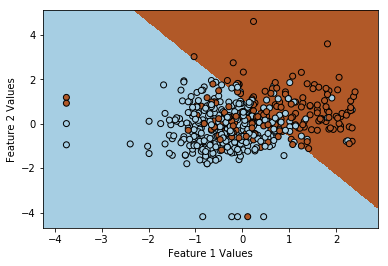

In [17]:
from matplotlib import pyplot as plt

model = LogisticRegression(penalty='l2', C=10, random_state=10).fit(X_train_2, y_train)
pred = model.predict(X_test_2)

x_min = X_train_2.iloc[:,[0]].min() - .5
x_max = X_train_2.iloc[:, [0]].max() + .5
y_min = X_train_2.iloc[:, [1]].min() - .5
y_max = X_train_2.iloc[:, [1]].max() + .5

h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min.values, x_max.values, h), np.arange(y_min.values, y_max.values, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

plt.scatter(X_train_2.iloc[:, 0], X_train_2.iloc[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 1 Values')
plt.ylabel('Feature 2 Values')

# Question 4 - Comparison of different ensembles method for classification (25 pts)

In this question, we will compare performance of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifiers.

[Spam Classification Data](https://archive.ics.uci.edu/ml/datasets/Spambase) of UCI will be used (you can use the data provided: 'spam_uci.csv'). Don't worry about column names. The last column represents target label, 1 if spam and zero otherwise.

* Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 



**Part 1: (4 pts)** Use a Decision Tree Classifier with random_state = 10 and Logistic Regression with random_state = 10 and solver ="lbfgs" for the spam classification problem. Report the accuracy_score and roc_auc_score on the test data for each classifier.


**Part 2: (8 pts)** Create an ensemble of 50 classifiers (i.e n_estimators = 50) with random_state = 10 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifier as Decision Tree Classifier and Logistic Regression from part $1$ . Report accuracy_score and roc_auc_score on the test data for both the Bagging classifiers. Compare the results and breifly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifier.


* Now we will look at the effect of other ensemble methods on this problem.


**Part 3: (5 pts)** Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify whether an email is spam. Report your testing accuracy ([accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score). You will need [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) for roc_auc_score. 


**Part 4: (5 pts)** Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for the spam classification problem.  Report  accuracy_score and roc_auc_score on the test data for each algorithm. 

  Note : For part 3 and 4 find the best values for the hyper parameters of each of the models by using GridSearchCV. 


**Part 5: (3 pts)** Briefly explain which of the three ensemble method above from Part 3&4 performed the best and why?


# Solution

#### Loading and pre-processing dataset

In [18]:
spam = pd.read_csv('spam_uci.csv', index_col=0)
y = spam.iloc[:, -1:]
X = spam.iloc[:, :-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

#### Part 1 (**4 pts**)

In [19]:
from sklearn.metrics import roc_auc_score

tree = DecisionTreeClassifier(random_state = 10).fit(X_train, y_train)
logreg = LogisticRegression(random_state = 10, solver='lbfgs').fit(X_train, y_train)

tree_pred = tree.predict(X_test)
logreg_pred = logreg.predict(X_test)

tree_acc = accuracy_score(y_test, tree_pred)
logreg_acc = accuracy_score(y_test, logreg_pred)

tree_roc = roc_auc_score(y_test, tree_pred)
logreg_roc = roc_auc_score(y_test, logreg_pred)

print('Tree accuracy is: {}'.format(tree_acc))
print('Tree ROC score is: {}\n'.format(tree_roc))
print('Log Reg accuracy is: {}'.format(logreg_acc))
print('Log Reg ROC score is: {}'.format(logreg_roc))

Tree accuracy is: 0.9117840684660962
Tree ROC score is: 0.9085903594264297

Log Reg accuracy is: 0.923633969716919
Log Reg ROC score is: 0.9205528156080722


#### Part 2 (**8 pts**)
Create an ensemble of 50 classifiers (i.e n_estimators = 50) with random_state = 10 for bagging with base classifier as Decision Tree Classifier and Logistic Regression from part  1
1
  . Report accuracy_score and roc_auc_score on the test data for both the Bagging classifiers. Compare the results and breifly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifier.

In [20]:
from sklearn.ensemble import BaggingClassifier

BCTree = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators = 50, random_state = 10).fit(X_train, y_train)
BCLogReg = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators = 50, random_state = 10).fit(X_train, y_train)

BCTree_pred = BCTree.predict(X_test)
BCLogReg_pred = BCLogReg.predict(X_test)

Tree_acc = accuracy_score(y_test, BCTree_pred)
LogReg_acc = accuracy_score(y_test, BCLogReg_pred)

tree_roc = roc_auc_score(y_test, BCTree_pred)
logreg_roc = roc_auc_score(y_test, BCLogReg_pred)

print('Tree accuracy is: {}'.format(Tree_acc))
print('Tree ROC score is: {}\n'.format(tree_roc))
print('Log Reg accuracy is: {}'.format(LogReg_acc))
print('Log Reg ROC score is: {}'.format(logreg_roc))

Tree accuracy is: 0.9447004608294931
Tree ROC score is: 0.9415437256391329

Log Reg accuracy is: 0.9262672811059908
Log Reg ROC score is: 0.9234868179402964


#### Part 3 (**5 pts**)
Use a Random Forest to classify whether an email is spam. Report your testing accuracy (accuracy_score) and roc_auc_score. You will need predict_proba for roc_auc_score.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [10,30,100,200], 'criterion':('gini', 'entropy'), 'max_depth':[5,10,15,20]}
model = RandomForestClassifier(random_state=10)
grid = GridSearchCV(model, params).fit(X_train, y_train)


pred = grid.predict(X_test)

acc = accuracy_score(y_test, pred)
probs = grid.predict_proba(X_test)

#print(probs, y_test)
roc = roc_auc_score(y_test, probs[:,1])
print('Random Forest accuracy is: {}'.format(acc))
print('Random Forest ROC score is: {}'.format(roc))
print(grid.best_params_)

Random Forest accuracy is: 0.9585253456221198
Random Forest ROC score is: 0.9892785438932454
{'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 200}


#### Part 4 (**5 pts**)
Use Gradient Boosting Decision Tree (GBDT), and AdaBoost for the spam classification problem. Report accuracy_score and roc_auc_score on the test data for each algorithm.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

params = {'learning_rate': np.linspace(.001, 10, 50), 'n_estimators': [10,30,100,200]}
model = GradientBoostingClassifier(random_state=10)
grid = GridSearchCV(model, params).fit(X_train, y_train)

pred = grid.predict(X_test)
probs = grid.predict_proba(X_test)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, probs[:,1])

print('Gradient Boosted accuracy is: {}'.format(acc))
print('Gradient Boosted ROC score is: {}'.format(auc))
print('Gradient Boosted learning rate is {}'.format(grid.best_params_['learning_rate']))
print('Gradient Boosted n_estimators is {}'.format(grid.best_params_['n_estimators']))

Gradient Boosted accuracy is: 0.9486504279131007
Gradient Boosted ROC score is: 0.9778474354448166
Gradient Boosted learning rate is 0.6131836734693878
Gradient Boosted n_estimators is 200


In [24]:
params = {'learning_rate': np.linspace(.001, 10, 50), 'n_estimators': [10,30,100,200]}
model = AdaBoostClassifier(random_state=10)
grid = GridSearchCV(model, params).fit(X_train, y_train)

pred = grid.predict(X_test)
probs = grid.predict_proba(X_test)

acc = accuracy_score(y_test, pred)
auc = roc_auc_score(y_test, probs[:,1])

print('AdaBoost accuracy is: {}'.format(acc))
print('AdaBoost ROC score is: {}'.format(auc))
print('AdaBoost learning rate is {}'.format(grid.best_params_['learning_rate']))
print('AdaBoost n_estimators is {}'.format(grid.best_params_['n_estimators']))

AdaBoost accuracy is: 0.9466754443712969
AdaBoost ROC score is: 0.9860066543279877
AdaBoost learning rate is 0.20506122448979594
AdaBoost n_estimators is 200


#### Part 5 (**3 pts**)

The best model from parts 3 and 4 was the Random Forest ensemble model. The high variance per tree, when combined together, smoothed out the volatility and provided strong prediction accuracy. 


# Question 5 (Bonus): Segmenting Customers for Predicting Loan Repayment (40 points)

Download dataset from [this link](https://drive.google.com/file/d/1U6FDSQQSUzvw3Ygtgp8I5ea0-dL-orSE/view?usp=sharing).

In this question, we will look at a technique to segment customers using SHAP (SHapley Additive exPlanations). Please read this article to learn about SHAP - https://christophm.github.io/interpretable-ml-book/shap.html.

SHAP values provide an explanation for each observation in terms of feature attribution (which features were most influential in determining the predicted value for that observation).

For some applications, that may be too fine a resolution, and one would rather identify subsets of observations (called segments or clusters) for which the “explanations are similar”, Moreover, it helps if subsets are also “understandable”, i.e. easy to describe in terms of the feature values. Then the subsets become “actionable”, as one can design specific interventions (e.g. targeted marketing messages) for each subset.

The goal of this problem is to identify such segments, and see if the variation of SHAP values within each segment is indeed lower than the variation in the total population. We will proceed as follows:

1. First, we will fit an XGBoost model to perform the classification task.
2. We will then use the shap.TreeExplainer which uses Tree SHAP algorithms and estimate the SHAP values for each observation.
3. Our objective is to segment customers into groups which have low variance in the SHAP values - these represent segments of similar customers in the “feature attribution based explanation” space. We will do this as follows:  

    a. Cluster the SHAP values using KMeans clustering. You pick K, perhaps somewhere between 10 and 20.  
    b. Build a decision tree with the Cluster numbers as the labels. Specify the number of leaves to be in the range of [K, 2K].  Due to the choice of the surrogate class labels provided by the clustering, the   leaves of the decision tree will be encouraged to have similar SHAP values. Moreover, since you are learning a decision tree, these leaves are also simple to describe as rules. A good solution will be indicated if  for each of these leaves,  the variance of SHAP values of observations mapped to that leaf will be lower than the  overall variance.  


In [29]:
#LOADING DATA -  DONOT CHANGE
import re
import pandas as pd
import numpy as np
import shap
import time
import xgboost
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the csv file and fill Nan/empty values as 0
dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

# We will be using only two classes and group them as below
def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

# Set of features which indicate the dimensionality of the data
df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]

#For simplicity, in this question, we select all columns that do not contain integer of float type of data. Then, one hot encoding is performed.
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)


X = df
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

X = X.drop(['loan_status'], axis=1)
Y = df['loan_status']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42)

### 5.1. Fit an XGBoost model on the train data and report the ROCAUC on the test set. (5pts)
### 5.2. Compute the SHAP values using the [TreeExplainer](https://shap.readthedocs.io/en/latest/generated/shap.TreeExplainer.html) and plot the [summary plot](https://shap.readthedocs.io/en/latest/generated/shap.summary_plot.html). Explain what the summary plot represents.(5 pts)
### 5.3. Perform KMeans clustering on the SHAP values inot $k$ clusters. Then, train a decision tree (with maximum depth $d$) to predict the cluster number obtained through KMeans -  the cluster numbers as the target. Visualize the decison tree (5 pts). Plot the variance of the SHAP values of the samples in each of the leaves - show that all these varinces is less than the overall variance of the SHAP values. The main parameters to tune here are the number of cluster $k$ and the maximum depth $d$. **(30 pts)**

In [50]:
dtrain = xgboost.DMatrix(X_train_val, label = y_train_val)
dtest = xgboost.DMatrix(X_test)

params = {'booster':'gbtree', 'eta':0.1}
num_rounds = 3

boost = xgboost.train(params, dtrain, num_rounds)
pred = boost.predict(dtest)

print('The ROC_AUC is: {}'.format(roc_auc_score(y_test, pred)))

The ROC_AUC is: 0.9475369714235595
